# `Kerchunk` tutorial

Created July 2021 by [Lucas Sterzinger](mailto:lsterzinger@ucdavis.edu) ([Twitter](https://twitter.com/lucassterzinger)) as part of the NCAR [Summer Internship in Parallel Computational Science (SIParCS)](https://www2.cisl.ucar.edu/siparcs)

If any part of this tutorial is now out of date, please feel free to open a pull request with a fix

In [1]:
import os
os.chdir('/work')

### Import Kerchunk

In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import fsspec
import ujson
from tqdm import tqdm
from glob import glob
import os

### Dask makes some of the processing faster, but it is not required to run this tutorial.
This code block starts 8 local dask workers

In [4]:
import dask
from dask.distributed import Client, LocalCluster
from dask_cloudprovider.aws import FargateCluster, EC2Cluster

# Start a local Dask cluster
cluster = LocalCluster(n_workers=8)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 3.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42035,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 3.76 GiB
Comm: tcp://127.0.0.1:34443,Total threads: 1
Dashboard: http://127.0.0.1:34401/status,Memory: 481.11 MiB
Nanny: tcp://127.0.0.1:34871,


## Create metadata JSONs

### Get a list of S3 files for the 210th day of 2020 (July 28, 2020) and prepend `s3://` to each url

In [5]:
fs = fsspec.filesystem('s3', anon=True)

urls = ['s3://' + f for f in fs.glob("s3://noaa-goes16/ABI-L2-SSTF/2020/210/*/*.nc")]

## Create Reference JSONS
### This function creates JSON metadata files for each of the S3 files in the local `jsons/` directory

These files point to the S3 location of the netCDF files, and only need to be created once. Tihs process took me about 10 minutes to generate the JSONs for 24 files. This function could easily be made to run in parallel for faster performance

In [6]:
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False, default_cache_type="none"
    )
    with fsspec.open(u, **so) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"./jsons/{u.split('/')[-1]}.json", 'wb') as outf:
            outf.write(ujson.dumps(h5chunks.translate()).encode())


In [7]:
# Create json/ folder if it doesn't already exist
import pathlib
pathlib.Path('./jsons/').mkdir(exist_ok=True)

Run the `gen_json()` function defined above with dask. This function can be run in parallel with each worker creating a single file. If you do not want to use dask, replace the uncommented line with the commented block below it.

In [8]:
dask.compute(*[dask.delayed(gen_json)(u) for u in urls]);

# If not using dask, use
# for u in tqdm(urls):
#     gen_json(u)


***
## Read remote netCDF files with xarray and fsspec

### First, create a list of JSON files

In [9]:
json_list = sorted(glob("/work/jsons/*.json"))

### Then, loop over the files and use `fsspec.get_mapper()` to create mappers for each file object, creating a list of mappers

In [10]:
m_list = []
for j in tqdm(json_list):
    with open(j) as f:
        m_list.append(fsspec.get_mapper("reference://", 
                        fo=ujson.load(f),
                        remote_protocol='s3',
                        remote_options={'anon':True}))

100%|██████████| 24/24 [00:00<00:00, 40.19it/s]


### Now, the mapper list can be passed directly to xarray.open_mfdataset() as long as the engine is specified as "zarr"


In [11]:
%%time
ds = xr.open_mfdataset(m_list, engine='zarr', combine='nested', concat_dim='t', 
                        coords='minimal', data_vars='minimal', compat='override',
                        parallel=True)
ds

/opt/conda/lib/python3.8/site-packages/dask/utils.py:73: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return func(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/dask/utils.py:73: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=F

CPU times: user 4.88 s, sys: 765 ms, total: 5.64 s
Wall time: 15.6 s


<xarray.Dataset>
Dimensions:                                                 (t: 24, y: 5424,
                                                             x: 5424,
                                                             SST_day_night_emissive_bands: 4,
                                                             SST_night_only_emissive_band: 1,
                                                             number_of_SZA_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2)
Coordinates: (12/14)
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    day_solar_zenith_angle                                  float32 ...
    night_solar_zenith_angle                                float32 ...
    ...                                                      ...
    retrieval_solar_zenith_angle                            float32 ...
  * t                                                       (t) datetime64[ns] ...
  * x                                                       (x) float64 -0.15...
    x_image                                                 float32 ...
  * y                                                       (y) float64 0.151...
    y_image                                                 float32 ...
Dimensions without coordinates: SST_day_night_emissive_bands,
                                SST_night_only_emissive_band,
                                number_of_SZA_bounds, number_of_LZA_bounds,
                                number_of_time_bounds, number_of_image_bounds
Data variables: (12/42)
    DQF                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    SST                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (t) float64 nan ....
    algorithm_product_version_container                     (t) float64 nan ....
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (t) float64 nan ....
    ...                                                      ...
    total_number_of_severely_degraded_quality_ocean_pixels  (t) float64 1.237...
    total_number_of_unprocessed_pixels                      (t) float64 1.256...
    twilight_solar_zenith_angle                             (t) float64 85.0 ...
    twilight_solar_zenith_angle_bounds                      (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    y_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/33)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    dataset_name:              OR_ABI-L2-SSTF-M6_G16_s20202100000205_e2020210...
    date_created:              2020-07-28T0

# One JSON, multiple data files

The 1-file, 1-JSON method above doesn't scale well for larger datasets.
Instead, we can combine multiple JSONS into a single JSON describing the whole dataset.

In [12]:
mzz = MultiZarrToZarr(
    json_list,
    remote_protocol="s3",
    remote_options={'anon':True},
    concat_dims='t',
    inline_threshold=0
)

This part actually writes the metadata to a file

In [13]:
%%time
mzz.translate("/work/combined.json")

CPU times: user 2.44 s, sys: 282 ms, total: 2.72 s
Wall time: 3.72 s


{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  't/.zarray': '{\n    "chunks": [\n        24\n    ],\n    "compressor": null,\n    "dtype": "<f8",\n    "fill_value": null,\n    "filters": null,\n    "order": "C",\n    "shape": [\n        24\n    ],\n    "zarr_format": 2\n}',
  't/0': 'base64:/5H3psJYw0Gpa/OuyVjDQe6v7rbQWMNBYRbqvtdYw0HrHOXG3ljDQR/y7s7lWMNBKLj41uxYw0FxkfPe81jDQWLZ7ub6WMNBMnXp7gFZw0EtluT2CFnDQV6+3/4PWcNBe93cBhdZw0G6wNsOHlnDQTMa2xYlWcNBfR/YHixZw0FRbNMmM1nDQbDlvy46WcNBUWmsNkFZw0EBpac+SFnDQfD6okZPWcNB5SaeTlZZw0HToZlWXVnDQTljlF5kWcNB',
  't/.zattrs': '{\n    "_ARRAY_DIMENSIONS": [\n        "t"\n    ],\n    "axis": "T",\n    "bounds": "time_bounds",\n    "long_name": "J2000 epoch mid-point between the start and end image scan in seconds",\n    "standard_name": "time",\n    "units": "seconds since 2000-01-01 12:00:00"\n}',
  '.zattrs': '{"Conventions":"CF-1.7","Metadata_Conventions":"Unidata Dataset Discovery v1.0","cdm_data_type":"Image","cell_methods":"quantitative

## Now, use the `combined.json` file to open the multifile dataset

In [14]:
%%time
fs = fsspec.filesystem("reference", fo="/work/combined.json", remote_protocol="s3", 
                        remote_options={"anon":True}, skip_instance_cache=True)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr')

ds

<timed exec>:4: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


CPU times: user 434 ms, sys: 65.8 ms, total: 500 ms
Wall time: 727 ms


<xarray.Dataset>
Dimensions:                                                 (t: 24, y: 5424,
                                                             x: 5424,
                                                             SST_day_night_emissive_bands: 4,
                                                             SST_night_only_emissive_band: 1,
                                                             number_of_SZA_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2)
Coordinates: (12/14)
    SST_day_night_emissive_band_ids                         (t, SST_day_night_emissive_bands) float32 ...
    SST_day_night_emissive_wavelengths                      (t, SST_day_night_emissive_bands) float32 ...
    SST_night_only_emissive_band_id                         (t, SST_night_only_emissive_band) int8 ...
    SST_night_only_emissive_wavelength                      (t, SST_night_only_emissive_band) float32 ...
    day_solar_zenith_angle                                  (t) float32 ...
    night_solar_zenith_angle                                (t) float32 ...
    ...                                                      ...
    retrieval_solar_zenith_angle                            (t) float32 ...
  * t                                                       (t) datetime64[ns] ...
  * x                                                       (x) float64 -0.15...
    x_image                                                 (t) float32 ...
  * y                                                       (y) float64 0.151...
    y_image                                                 (t) float32 ...
Dimensions without coordinates: SST_day_night_emissive_bands,
                                SST_night_only_emissive_band,
                                number_of_SZA_bounds, number_of_LZA_bounds,
                                number_of_time_bounds, number_of_image_bounds
Data variables: (12/42)
    DQF                                                     (t, y, x) float32 ...
    SST                                                     (t, y, x) float32 ...
    algorithm_dynamic_input_data_container                  (t) float64 ...
    algorithm_product_version_container                     (t) float64 ...
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 ...
    geospatial_lat_lon_extent                               (t) float32 ...
    ...                                                      ...
    total_number_of_severely_degraded_quality_ocean_pixels  (t) float64 ...
    total_number_of_unprocessed_pixels                      (t) float64 ...
    twilight_solar_zenith_angle                             (t) float32 ...
    twilight_solar_zenith_angle_bounds                      (t, number_of_SZA_bounds) float32 ...
    x_image_bounds                                          (t, number_of_image_bounds) float32 ...
    y_image_bounds                                          (t, number_of_image_bounds) float32 ...
Attributes: (12/33)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    dataset_name:              OR_ABI-L2-SSTF-M6_G16_s20202100000205_e2020210...
    date_created:              2020-07-28T01:05:45.6Z
    ...                        ...
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    time_coverage_end:         2020-07-28T00:59:51.3Z
    time_coverage_start:       2020-07-28T00:00:20.5Z
    timeline_id:               ABI Mode 6
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

### Take a subset of the data (in this case, the Gulf Stream)

### Select a single time with `.isel(t=14)`

CPU times: user 3.59 s, sys: 965 ms, total: 4.55 s
Wall time: 6.66 s


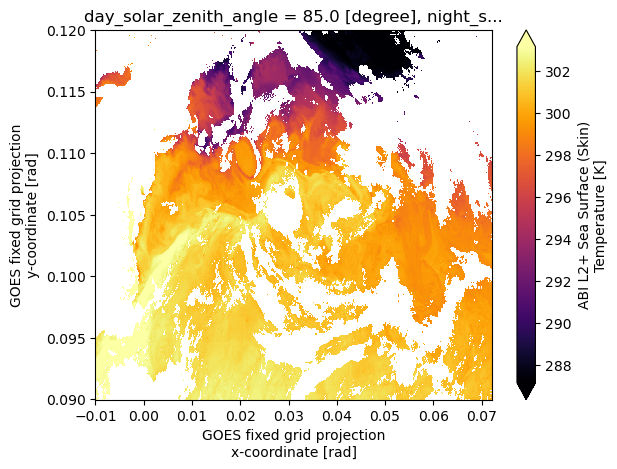

In [15]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.isel(t=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

### Plot a mean along the time axis (1-day average)

CPU times: user 3.44 s, sys: 624 ms, total: 4.07 s
Wall time: 5.32 s


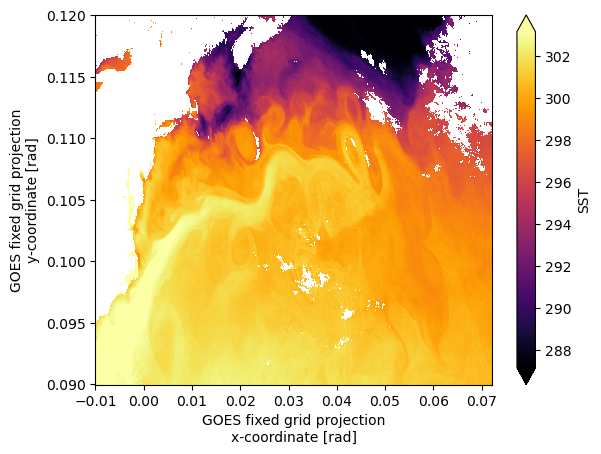

In [16]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.mean("t", skipna=True).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

### For details on how to plot GOES data on a lat/lon grid, see [this blog post I wrote](https://lsterzinger.medium.com/add-lat-lon-coordinates-to-goes-16-goes-17-l2-data-and-plot-with-cartopy-27f07879157f)

In [17]:
client.close()
cluster.close()

2025-04-11 09:51:07,150 - distributed.nanny - WARNING - Worker process still alive after 3.1999983215332035 seconds, killing
2025-04-11 09:51:07,158 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2025-04-11 09:51:07,167 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-04-11 09:51:07,183 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-04-11 09:51:07,196 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-04-11 09:51:07,213 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2025-04-11 09:51:07,224 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2025-04-11 09:51:07,245 - distributed.nanny - WARNING - Worker process still alive after 3.1999980163574224 seconds, killing
